In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import os
import re
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
fn = '20230330-175814.txt'

The textfile is full of lines with several thins. Timestamps, then Z and X are the coordinates of the mouse in space and can be neagative if moving backwards. reward_positioned and reward_delivered indicate the position of a reward beacon and when/where it has been delivered. Ignore everything else.


In [13]:
# Define regular expressions
position_regex = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{2}).*X=(-?\d+\.\d+) Z=(-?\d+\.\d+) Rot=')
reward_regex = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{2}).*Reward_delivered@ X=(-?\d+\.\d+) Z=(-?\d+\.\d+)')

# Initialize lists and arrays for position and reward data
pos_x = []
pos_z = []
pos_timestamps = []
reward_x = []
reward_z = []
reward_timestamps = []

# Read the text file
with open(fn, 'r') as file:
    # Process each line in the file
    for line in file:
        
        posmatched = False 
        
        # Extract X and Z coordinates and timestamp for position lines
        match = position_regex.search(line)
        if match:
            
            posmatched = True 
            timestamp = match.group(1)
            x_coordinate = float(match.group(2))
            z_coordinate = float(match.group(3))

            # Append coordinates to the respective lists
            pos_x.append(x_coordinate)
            pos_z.append(z_coordinate)

            # Append timestamp to the list
            pos_timestamps.append(timestamp)
        
        # Extract X and Z coordinates and timestamp for reward lines
        reward_match = reward_regex.search(line)
        if reward_match:
            
            if posmatched:
                print('both posmatch and reward match')
            timestamp = reward_match.group(1)
            x_coordinate = float(reward_match.group(2))
            z_coordinate = float(reward_match.group(3))

            # Append coordinates to the respective lists
            reward_x.append(x_coordinate)
            reward_z.append(z_coordinate)

            # Append timestamp to the list
            reward_timestamps.append(timestamp)

# Convert lists to numpy arrays
pos_x = np.array(pos_x)
pos_z = np.array(pos_z)
pos_timestamps = np.array(pos_timestamps)
reward_x = np.array(reward_x)
reward_z = np.array(reward_z)
reward_timestamps = np.array(reward_timestamps)

# Convert timestamps to datetime objects
pos_datetime = [datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.%f") for timestamp in pos_timestamps]
reward_datetime = [datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.%f") for timestamp in reward_timestamps]

# Calculate time differences in seconds from the first sample
pos_time_diffs = [(timestamp - pos_datetime[0]).total_seconds() for timestamp in pos_datetime]
reward_time_diffs = [(timestamp - pos_datetime[0]).total_seconds() for timestamp in reward_datetime]

# Create pos_times and reward_times arrays starting from zero
pos_times = np.array(pos_time_diffs)
reward_times = np.array(reward_time_diffs)


In [33]:
np.diff(pos_times)

array([0.01, 0.  , 0.05, ..., 0.  , 0.05, 0.01])

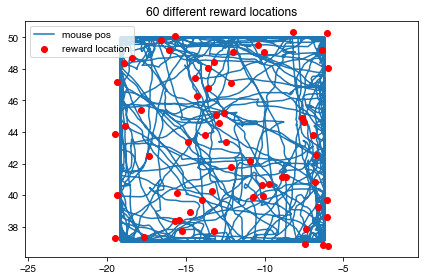

In [15]:
fig, axes = plt.subplots()
plt.title('{} different reward locations'.format(len(reward_x)))

plt.plot(pos_x, pos_z)
plt.scatter(reward_x, reward_z, color='r', zorder=20)
plt.legend(['mouse pos', 'reward location'], loc='upper left')
plt.axis('equal')
plt.tight_layout()

In [16]:
n_trajectories = len(reward_x)

def trial_pos_mask(idx):
    if idx == 0: 
        return pos_times <= reward_times[idx]
    elif (idx > 0) & (idx < len(reward_times)):
        return (pos_times > reward_times[idx-1]) & (pos_times <= reward_times[idx])
    else:
        return None
    

(-16.85088531453324, -5.698825175498417, 41.61134553533887, 50.55466375788377)

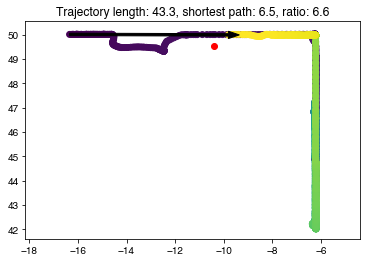

In [44]:
trial_n = 21


mask = trial_pos_mask(trial_n)
xpos = pos_x[mask]
zpos = pos_z[mask]

trajectory_length = np.sqrt(np.diff(xpos)**2 + np.diff(zpos)**2).sum()
shortest_path = np.sqrt((xpos[-1] - xpos[0])**2 + (zpos[-1] - zpos[0])**2)

c = np.arange(len(xpos))
plt.scatter(xpos, zpos, c=c)
plt.scatter(reward_x[trial_n], reward_z[trial_n], color='r')

plt.arrow(xpos[0], zpos[0], xpos[-1] - xpos[0], zpos[-1] - zpos[0], width=.1, edgecolor=None, facecolor='k') 

plt.title('Trajectory length: {:.1f}, shortest path: {:.1f}, ratio: {:.1f}'.format(trajectory_length,
                                                                      shortest_path,
                                                                      trajectory_length/ shortest_path))

plt.xlim([pos_x.min(), pos_x.max()])
plt.ylim([pos_z.min(), pos_z.max()])
plt.axis('equal')

Note that some of the trajectories don't look quite as nice as this one. Some of the X, Y positions have erroneous jumps in them which of course makes the trajectory length look longer than it is. This'll need some smoothing. 